# Moodify: Spotify Song Emotion Predictor

**Moodify** is a machine learning project that predicts the emotional category of Spotify tracks based on their audio features. The project builds a predictive model that analyzes features such as danceability, energy, valence, tempo, acousticness, and more, to classify songs into one of four emotion labels: **Sad, Happy, Energetic, or Calm**.  

The system enables:  
- Accurate prediction of song emotions from audio features.  
- Insight into which audio features contribute most to emotional perception.  
- Support for personalized music recommendations based on predicted emotions. 

In [1]:
# -------------------------------------------------------------
# Importing Required Libraries
# -------------------------------------------------------------
# Data handling and numerical computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy.stats import skew, kurtosis
import scipy.stats as stats

# Machine learning preprocessing and evaluation tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report, roc_auc_score

# Advanced gradient boosting models
import lightgbm as LGB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Configuration and general settings
import pickle
import warnings
warnings.filterwarnings("ignore")
sns.set()


## Data Overview

In this section, the dataset is first **loaded** and then inspected to understand its structure, quality, and readiness for modeling.

The following checks are performed:

- Examination of dataset shape (number of rows and columns)
- Inspection of column names and data types
- Summary statistics using descriptive analysis
- Detection of missing values
- Identification of duplicate records
- Review of unique values per feature
- Initial inspection of the target variable (labels)

These checks help ensure the dataset is clean, consistent, and suitable for supervised multi-class classification before proceeding to exploratory data analysis and model development.


In [2]:
# Read the CSV file into a pandas DataFrame

df = pd.read_csv(r"C:\Users\AKANBI BENJAMIN\Documents\278k_song_labelled.csv")

In [3]:
# Display the first 5 rows to preview the dataset

df.head()

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


In [4]:
# Display general information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        277938 non-null  int64  
 1   duration (ms)     277938 non-null  float64
 2   danceability      277938 non-null  float64
 3   energy            277938 non-null  float64
 4   loudness          277938 non-null  float64
 5   speechiness       277938 non-null  float64
 6   acousticness      277938 non-null  float64
 7   instrumentalness  277938 non-null  float64
 8   liveness          277938 non-null  float64
 9   valence           277938 non-null  float64
 10  tempo             277938 non-null  float64
 11  spec_rate         277938 non-null  float64
 12  labels            277938 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 27.6 MB


In [5]:
# Drop unnecessary column (likely an index column saved from previous export)

df = df.drop(columns = ["Unnamed: 0"])

In [6]:
# Generate descriptive statistics for numerical columns

df.describe()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
count,2.779380e+05,277938.000000,277938.000000,277938.000000,277938.000000,277938.000000,277938.000000,277938.000000,277938.000000,277938.000000,2.779380e+05,277938.000000
mean,2.324961e+05,0.552583,0.556866,-10.363654,0.087913,0.386583,0.255044,0.189217,0.449602,119.196002,4.754654e-07,1.179101
std,1.171830e+05,0.188905,0.279681,6.672049,0.112500,0.364504,0.373745,0.163596,0.267471,30.462256,9.190229e-07,1.021033
min,6.706000e+03,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.720130e+05,0.431000,0.342000,-12.747000,0.035900,0.033800,0.000000,0.096200,0.220000,95.072250,1.531461e-07,0.000000
50%,2.131055e+05,0.571000,0.591000,-8.397000,0.047100,0.262000,0.001090,0.121000,0.434000,119.940000,2.345459e-07,1.000000
75%,2.648660e+05,0.693000,0.792000,-5.842000,0.082200,0.754000,0.645000,0.227000,0.665000,138.869750,4.449937e-07,2.000000
max,3.919895e+06,0.989000,1.000000,4.882000,0.965000,0.996000,1.000000,1.000000,1.000000,244.947000,5.971860e-05,3.000000


In [7]:
# Display all column names

df.columns

Index(['duration (ms)', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'spec_rate', 'labels'],
      dtype='object')

In [8]:
# Check for missing values in each column

df.isna().sum()

duration (ms)       0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
spec_rate           0
labels              0
dtype: int64

In [9]:
# Count total number of duplicate rows

df.duplicated().sum()

1678

In [10]:
# Display first 20 duplicate rows for inspection

df[df.duplicated()].head(20)

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
1357,168842.0,0.667,0.8810,-3.366,0.0815,0.350000,0.000000,0.0742,0.7110,104.968,4.826998e-07,1
2998,172196.0,0.802,0.8200,-5.969,0.1460,0.057900,0.000000,0.1490,0.6130,164.005,8.478710e-07,1
3065,170053.0,0.797,0.6400,-6.272,0.1940,0.148000,0.000000,0.2090,0.4860,100.002,1.140821e-06,1
5658,198865.0,0.172,0.1280,-23.009,0.0345,0.908000,0.858000,0.0997,0.0849,92.737,1.734845e-07,3
6245,224947.0,0.488,0.8150,-4.354,0.0438,0.014800,0.002070,0.0744,0.0654,174.994,1.947125e-07,1
6842,305606.0,0.621,0.3700,-11.737,0.0924,0.539000,0.000000,0.0572,0.8800,127.468,3.023501e-07,1
7040,255543.0,0.250,0.6210,-6.153,0.0450,0.064700,0.000162,0.1060,0.4020,150.670,1.760956e-07,2
7061,425774.0,0.741,0.6490,-6.899,0.0445,0.012300,0.087000,0.0775,0.4420,117.929,1.045155e-07,1
7065,443127.0,0.596,0.5380,-8.212,0.0287,0.045700,0.723000,0.0951,0.5180,131.978,6.476699e-08,0
7224,190417.0,0.588,0.6970,-4.744,0.0372,0.186000,0.000219,0.1030,0.2250,125.157,1.953607e-07,1


In [11]:
# Remove duplicate rows from the dataset

df = df.drop_duplicates()

In [12]:
# Check the new shape of the dataset after removing duplicates

df.shape

(276260, 12)

In [13]:
# Check distribution of the target variable (class balance)

df['labels'].value_counts()

labels
1    105728
0     81628
2     46716
3     42188
Name: count, dtype: int64

In [14]:
# Check number of unique values in each column

df.nunique()

duration (ms)       114072
danceability          1327
energy                2778
loudness             32201
speechiness           1640
acousticness          5177
instrumentalness      5402
liveness              1766
valence               1941
tempo                93680
spec_rate           271731
labels                   4
dtype: int64

##  Data Cleaning Conclusion

The dataset was evaluated for quality issues before proceeding to modeling.

Key findings:

- No missing values were present across all features.
- All columns were already in appropriate numerical format.
- 1,678 exact duplicate rows (approximately 0.6% of the dataset) were identified.
- Duplicate rows were identical across all features and labels.

Since this is a supervised classification task and duplicate records do not provide additional learning value, all exact duplicates were removed to prevent potential model bias and ensure better generalization performance.

After removing duplicates, the dataset remains large and robust, containing over 276,000 unique observations. The cleaned dataset is now ready for exploratory analysis, feature engineering, and model training.


##  Exploratory Data Analysis (EDA)

In this section, we explore the dataset to uncover patterns, relationships, and distributions that will guide feature selection and model development.

The following analyses are performed:

- **Distribution analysis of audio features:** Understanding the range, mean, and spread of each numerical feature.
- **Correlation between features and target labels:** Identifying which audio features are most related to song emotions.
- **Class balance inspection:** Checking the distribution of the four emotion labels to ensure the dataset is not heavily imbalanced.
- **Visualization of feature patterns per label:** Using plots to observe how feature values vary across different emotional categories.

These EDA steps provide insights into the data and help inform preprocessing, feature engineering, and model choice.


In [15]:
# Define the factor columns (all numerical audio features)

factors = [
    'duration (ms)',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'spec_rate'
]

# Create a DataFrame to store summary statistics

summary_stats = []

# Loop through each factor column

for factor in factors:
    
    # Central tendency

    mean_val = df[factor].mean()
    median_val = df[factor].median()
    mode_val = df[factor].mode()[0]

    # Distribution shape
    
    skewness_val = skew(df[factor])
    kurtosis_val = kurtosis(df[factor], fisher=False)  # Pearson definition

    # Quartiles and whiskers
    
    Q1 = df[factor].quantile(0.25)
    Q3 = df[factor].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    # Minimum, Maximum, and Range
    
    min_val = df[factor].min()
    max_val = df[factor].max()
    range_val = max_val - min_val

    # Append stats as one record
    
    summary_stats.append({
        "Feature": factor,
        "Mean": round(mean_val, 3),
        "Median": round(median_val, 3),
        "Mode": round(mode_val, 3),
        "Skewness": round(skewness_val, 3),
        "Kurtosis": round(kurtosis_val, 3),
        "Q1": round(Q1, 3),
        "Q3": round(Q3, 3),
        "IQR": round(IQR, 3),
        "Lower Whisker": round(lower_whisker, 3),
        "Upper Whisker": round(upper_whisker, 3),
        "Min": round(min_val, 3),
        "Max": round(max_val, 3),
        "Range": round(range_val, 3)
    })

# Convert list of dictionaries to DataFrame

summary_df = pd.DataFrame(summary_stats)

# Display table

summary_df

,Feature,Mean,Median,Mode,Skewness,Kurtosis,Q1,Q3,IQR,Lower Whisker,Upper Whisker,Min,Max,Range
0,duration (ms),232422.060,213053.000,192000.000,6.069,100.800,172000.000,264845.500,92845.500,32731.750,404113.750,6706.0,3919895.000,3913189.000
1,danceability,0.553,0.571,0.565,-0.385,2.606,0.431,0.693,0.262,0.038,1.086,0.0,0.989,0.989
2,energy,0.557,0.591,0.727,-0.334,2.022,0.341,0.792,0.451,-0.335,1.469,0.0,1.000,1.000
3,loudness,-10.370,-8.406,-6.640,-1.604,5.839,-12.756,-5.848,6.908,-23.118,4.514,-60.0,4.882,64.882
4,speechiness,0.088,0.047,0.034,4.096,25.034,0.036,0.082,0.046,-0.034,0.152,0.0,0.965,0.965
5,acousticness,0.387,0.263,0.995,0.444,1.610,0.034,0.754,0.720,-1.046,1.834,0.0,0.996,0.996
6,instrumentalness,0.255,0.001,0.000,0.970,2.108,0.000,0.647,0.647,-0.970,1.618,0.0,1.000,1.000
7,liveness,0.189,0.121,0.111,2.397,9.379,0.096,0.226,0.130,-0.099,0.421,0.0,1.000,1.000
8,valence,0.450,0.434,0.961,0.175,1.936,0.220,0.665,0.445,-0.448,1.332,0.0,1.000,1.000
9,tempo,119.191,119.936,120.008,0.319,2.697,95.067,138.852,43.785,29.389,204.530,0.0,244.947,244.947


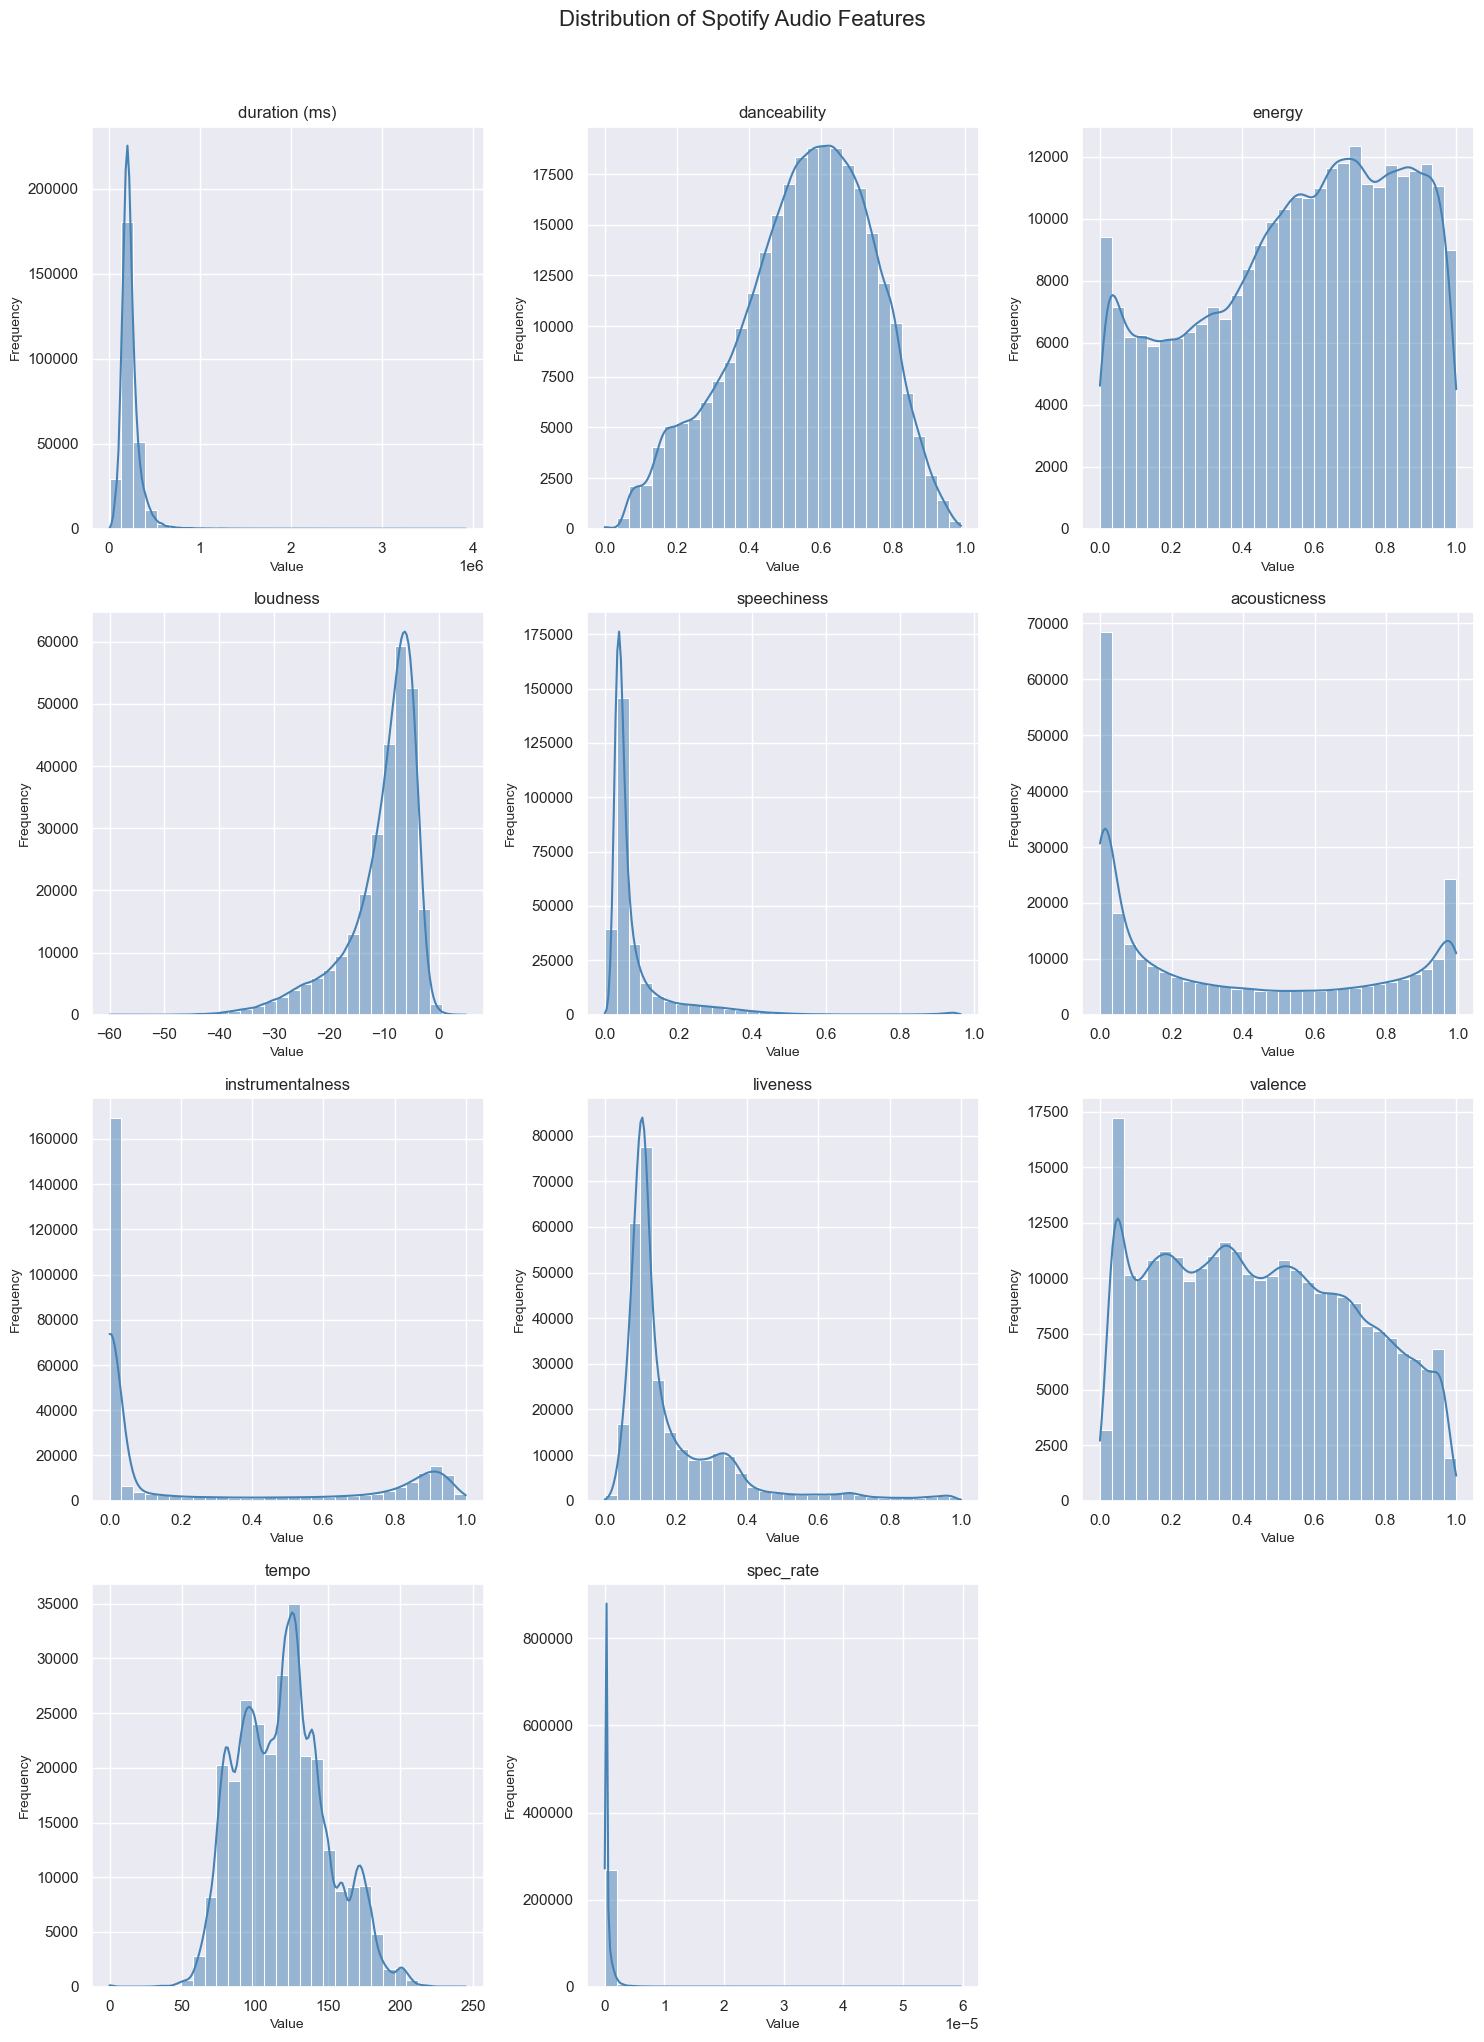

In [16]:
# Create a grid layout for multiple histograms

n_features = len(factors)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Loop through each factor and plot its histogram

for i, factor in enumerate(factors):
    sns.histplot(df[factor], bins=30, kde=True, color='steelblue', ax=axes[i])
    axes[i].set_title(f'{factor}', fontsize=12)
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Remove any unused axes

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single title for all subplots

plt.suptitle('Distribution of Spotify Audio Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Correlation of each feature with target label:
labels              1.000000
instrumentalness    0.541671
acousticness        0.053320
spec_rate           0.011944
tempo              -0.004581
speechiness        -0.006718
liveness           -0.019277
energy             -0.048792
duration (ms)      -0.114876
valence            -0.182283
danceability       -0.229615
loudness           -0.309649
Name: labels, dtype: float64


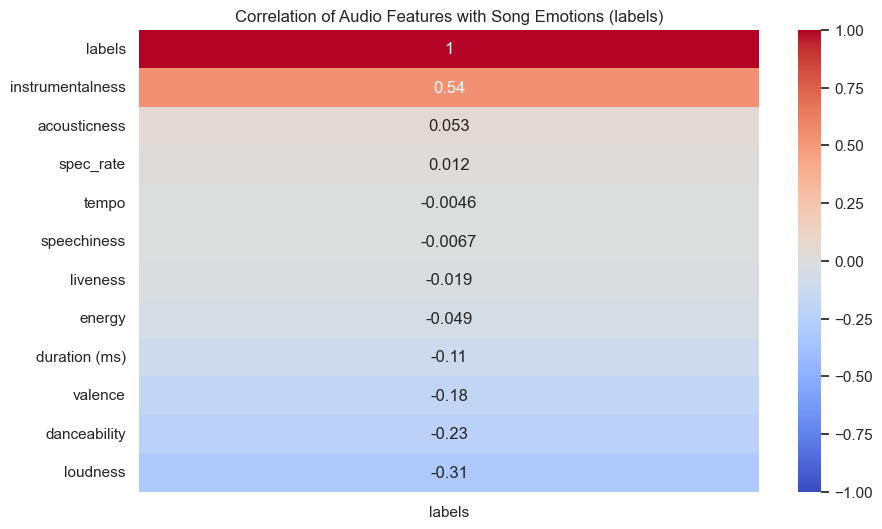

In [17]:
# Compute correlation matrix (features vs target label)

correlation_matrix = df.corr()

# Extract correlations with the target variable 'labels'

label_corr = correlation_matrix['labels'].sort_values(ascending=False)

# Display the correlations

print("Correlation of each feature with target label:")
print(label_corr)

#visualize correlations using a heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(label_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Audio Features with Song Emotions (labels)')
plt.show()

Number of tracks per emotion label:
labels
0     81628
1    105728
2     46716
3     42188
Name: count, dtype: int64


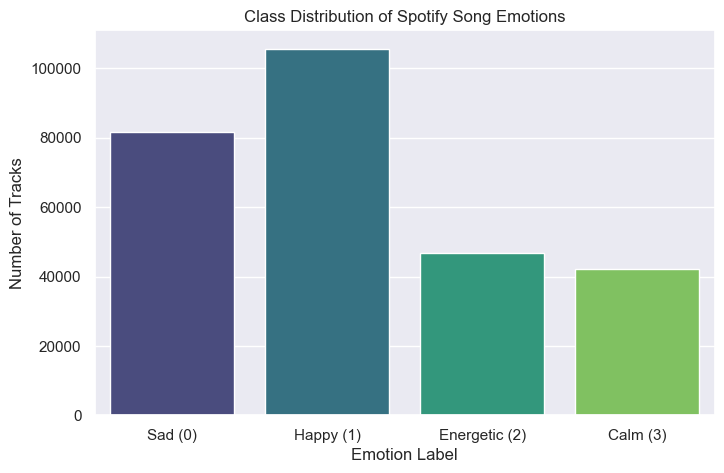

In [18]:
# Count the number of tracks in each emotion category

class_counts = df['labels'].value_counts().sort_index()

# Display class counts

print("Number of tracks per emotion label:")
print(class_counts)

#visualize class distribution

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Emotion Label')
plt.ylabel('Number of Tracks')
plt.title('Class Distribution of Spotify Song Emotions')
plt.xticks(ticks=[0,1,2,3], labels=['Sad (0)', 'Happy (1)', 'Energetic (2)', 'Calm (3)'])
plt.show()

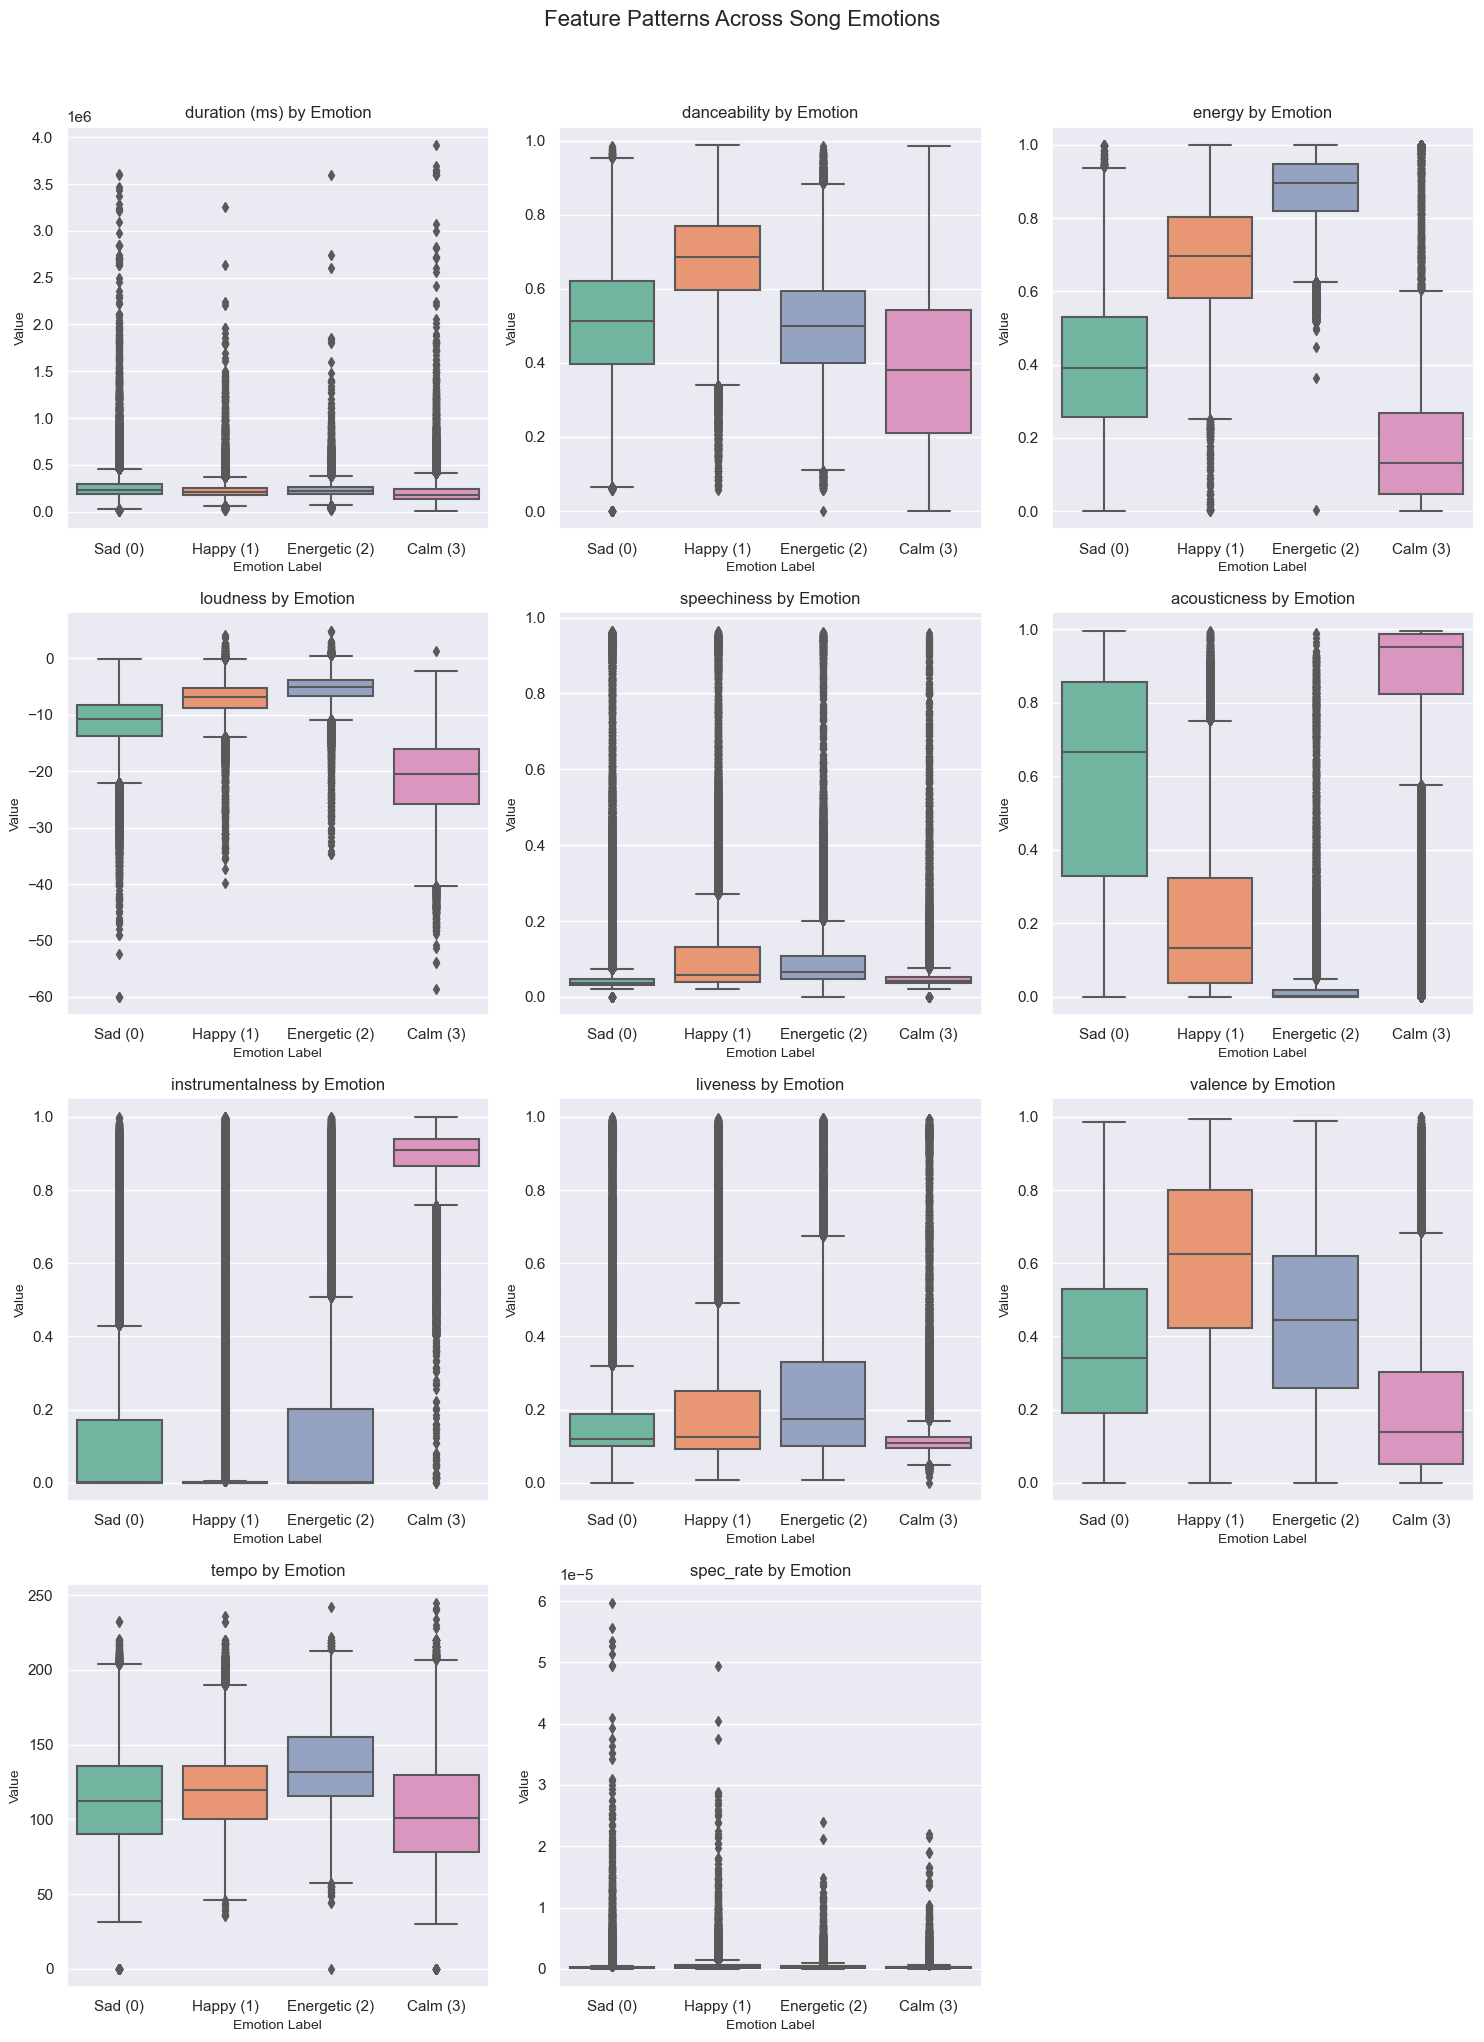

In [19]:
# Set up grid for multiple features

n_features = len(factors)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Loop through each feature and create a boxplot per emotion label

for i, feature in enumerate(factors):
    sns.boxplot(x='labels', y=feature, data=df, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature} by Emotion', fontsize=12)
    axes[i].set_xlabel('Emotion Label', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    axes[i].set_xticklabels(['Sad (0)', 'Happy (1)', 'Energetic (2)', 'Calm (3)'])

# Remove any unused axes

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a main title

plt.suptitle('Feature Patterns Across Song Emotions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA) Conclusion

The EDA provided a comprehensive understanding of the Spotify audio dataset and its relationship with song emotions:

- **Feature Distributions:**  
  Most audio features show varying distributions. Some are skewed (e.g., `duration (ms)`, `speechiness`, `spec_rate`), while others are roughly symmetric (e.g., `danceability`, `energy`). Boxplots reveal outliers in features like `loudness` and `instrumentalness`, which may require careful preprocessing.

- **Feature-Label Relationships:**  
  Correlation analysis indicates that `instrumentalness` is the strongest positive predictor of song emotion. Features such as `loudness`, `danceability`, and `valence` show negative correlations, highlighting their relevance for classification.

- **Class Balance:**  
  The dataset exhibits moderate imbalance across emotion labels: Happy (1) and Sad (0) are more frequent than Energetic (2) and Calm (3). This should be considered when training and evaluating models to avoid bias.

- **Feature Patterns Across Emotions:**  
  Boxplots reveal distinct patterns per emotion. For example, Calm tracks tend to have higher acousticness and lower energy, while Energetic tracks have higher loudness and energy. These patterns confirm that audio features provide meaningful signals for mood classification.

**Overall Insight:**  
The dataset is well-structured, with clear relationships between audio features and song emotions. Preprocessing steps such as handling skewed distributions, outliers, and class imbalance will enhance model performance. This EDA forms a solid foundation for feature engineering and supervised learning in the next stages of the project.


## Feature Scaling  

Before modeling, it is important to prepare the dataset through **scaling** to ensure that all features contribute proportionally and that the model converges efficiently.  

### Feature Scaling  
- All continuous audio features, such as **`duration (ms)`**, **`danceability`**, **`energy`**, **`loudness`**, **`speechiness`**, **`acousticness`**, **`instrumentalness`**, **`liveness`**, **`valence`**, **`tempo`**, and **`spec_rate`**, will be **standardized** using `StandardScaler`.  
- Scaling places all features on a similar scale, which is particularly important for models like **SVM, Logistic Regression, or Gradient Boosting** to avoid bias toward high-magnitude variables.

### Expected Outcome  
After this step:  
- All features will be numerical and normalized.  
- Each feature will contribute proportionally during model training.  
- The dataset will be ready for **train-test splitting** and **modeling**.


In [20]:
# Separate features (X) by dropping the target column 'labels'

X = df.drop(columns = ["labels"])

In [21]:
# Set the target variable (y) as the 'labels' column

y = df["labels"]

In [22]:
# Preview the first 5 rows of the feature set

X.head()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07


In [23]:
# Preview the first 5 rows of the target variable

y.head()

0    2
1    1
2    1
3    0
4    1
Name: labels, dtype: int64

In [24]:
# ----------------------------------------------------------
# Step: Feature Scaling
# Purpose: Normalize feature values to ensure that all 
#          numerical variables contribute equally to the model.
# ----------------------------------------------------------

# Initialize the StandardScaler

scale = StandardScaler()

# Fit the scaler on the feature dataset (X) and transform it
# This standardizes each feature to have mean = 0 and std = 1

scaledX = scale.fit_transform(X)

# Display the scaled feature array

scaledX

array([[-0.31980019,  0.30957371,  0.20517527, ...,  0.263365  ,
         0.29072937, -0.14261459],
       [-0.32286812,  0.4524755 ,  0.80225823, ..., -0.74588134,
         0.12451727, -0.35798319],
       [-0.1268966 ,  0.03964812,  0.90594329, ..., -0.75709519,
         1.66879668, -0.08157691],
       ...,
       [ 0.07592862, -0.13500962,  1.3778891 , ...,  0.16991626,
         0.9691307 , -0.35227754],
       [ 0.01633045,  1.14052114,  0.97387489, ...,  1.91553863,
        -0.01370294, -0.37194991],
       [ 0.08116718,  1.19874039,  1.12046412, ...,  0.39419323,
        -0.5415125 , -0.25926484]])

## Feature Scaling Conclusion

Feature scaling standardized all continuous audio attributes, ensuring that features with larger numeric ranges (e.g., `duration (ms)` or `loudness`) do not dominate the learning process.  

Key outcomes:  
- All audio features are now on a comparable scale, improving model stability and convergence.  
- Models sensitive to feature magnitudes, such as Logistic Regression, SVM, and Gradient Boosting, can effectively learn patterns without bias.  
- The dataset is fully prepared for train-test splitting and supervised learning, ready for model training and evaluation.


## Train–Test Split

**Goal:** Prepare the dataset for model training and evaluation.

### Tasks:
- Split the dataset into training and testing sets (e.g., 80% train, 20% test).
- Use **stratified sampling** to maintain the same proportion of failure vs. non-failure cases in both subsets.
- Verify the shape of each split to confirm successful separation.

In [25]:
# Split data into 80% training and 20% testing sets
# Using stratify=y to preserve the proportion of machine failures

X_train, X_test, y_train,y_test = train_test_split(scaledX, y, test_size = 0.2, random_state = 4)

# Display the shape of each subset to confirm successful split

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training set shape: (221008, 11)
Testing set shape: (55252, 11)
Training labels shape: (221008,)
Testing labels shape: (55252,)


## Train–Test Split – Conclusion

The dataset was successfully divided into **80% training data** and **20% testing data** using **stratified sampling**.  
This ensures that the **proportion of each emotion label** remains consistent across both subsets.  

The split prepares the dataset for model development:  
- The **training set** is used for learning patterns from the audio features.  
- The **test set** provides an unbiased evaluation of model performance, ensuring that results reflect real-world prediction capability.


## Model Building and Evaluation

### Goal
Train and compare multiple machine learning algorithms to accurately predict **song emotions** based on Spotify audio features.

### Models Explored
- Logistic Regression  
- Support Vector Machine (RBF Kernel)  
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost  

### Approach
- Utilized `X_train`, `X_test`, `y_train`, and `y_test` for model training and evaluation.  
- Implemented a **loop-based training pipeline** that:
  - Fits each model on the training dataset.  
  - Generates predictions on the test dataset.  
  - Computes key performance metrics: **Accuracy, Precision, Recall, F1-Score, and ROC-AUC**.  
  - Stores all metric results in a **DataFrame** for easy comparison.  
- Visualized **confusion matrices** for each model to examine true positives, false positives, true negatives, and false negatives.

In [26]:
# Initialize Logistic Regression

log_reg = LogisticRegression()

In [27]:
# Perform 10-fold cross-validation using weighted F1 score

scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="f1_weighted")

In [28]:
scores  # Display cross-validation scores

array([0.83956212, 0.83569428, 0.83788745, 0.84514959, 0.84069457,
       0.83929363, 0.83329275, 0.83905099, 0.83793785, 0.84257508])

In [29]:
# Fit model on training data

log_reg.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Predict on test set

log_preds = log_reg.predict(X_test)
log_preds

array([1, 3, 1, ..., 2, 1, 2], dtype=int64)

In [31]:
# Print classification report

print(classification_report(y_test, log_preds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     16280
           1       0.81      0.84      0.83     21256
           2       0.80      0.76      0.78      9308
           3       0.93      0.94      0.93      8408

    accuracy                           0.84     55252
   macro avg       0.85      0.84      0.84     55252
weighted avg       0.84      0.84      0.84     55252



In [32]:
# Predict probabilities for ROC AUC calculation

log_prob = log_reg.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, log_prob, multi_class='ovr', average='weighted')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9582566329159894


[[13319  2132   329   500]
 [ 1793 17936  1435    92]
 [  141  2045  7104    18]
 [  437    49     6  7916]]


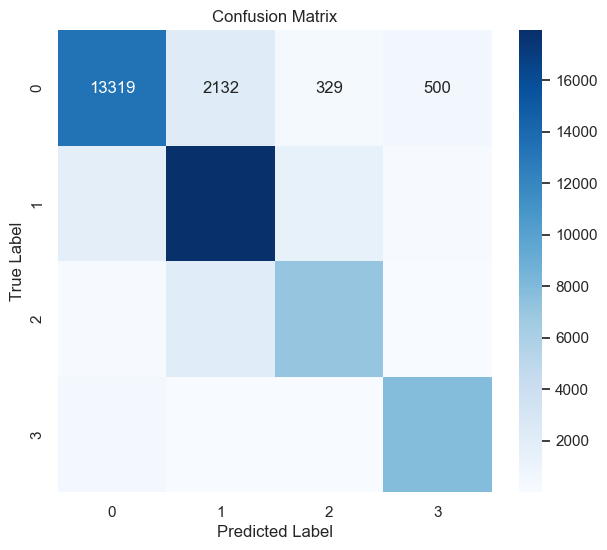

In [33]:
# Confusion matrix

log_cm = confusion_matrix(y_test, log_preds)
print(log_cm)

# Plot confusion matrix

plt.figure(figsize=(7,6))
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
# Initialize Decision Tree classifier

tree_class = DecisionTreeClassifier()

In [35]:
# 10-fold cross-validation

scores = cross_val_score(tree_class, X_train, y_train, cv=10, scoring="f1_weighted")
scores

array([0.90653981, 0.90626322, 0.90605542, 0.90649864, 0.90682394,
       0.90474221, 0.90585956, 0.90939374, 0.90911552, 0.9057276 ])

In [36]:
# Fit model

tree_class.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
# Predict on test set

tree_preds = tree_class.predict(X_test)
tree_preds

array([1, 3, 1, ..., 1, 1, 2], dtype=int64)

In [38]:
# Print classification report

print(classification_report(y_test, tree_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     16280
           1       0.90      0.90      0.90     21256
           2       0.85      0.85      0.85      9308
           3       0.96      0.96      0.96      8408

    accuracy                           0.91     55252
   macro avg       0.91      0.91      0.91     55252
weighted avg       0.91      0.91      0.91     55252



In [39]:
# Predict probabilities for ROC AUC

tree_prob = tree_class.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, tree_prob, multi_class='ovr', average='weighted')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9322202522995102


[[14949   925   176   230]
 [  908 19089  1168    91]
 [  168  1198  7925    17]
 [  231    93    17  8067]]


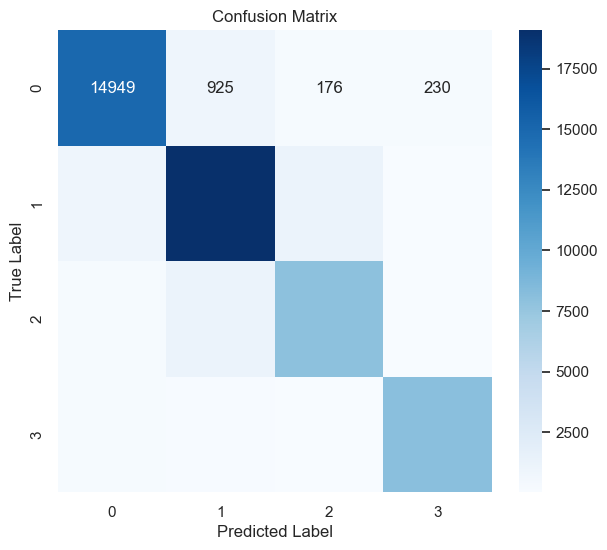

In [40]:
# Confusion matrix

tree_cm = confusion_matrix(y_test, tree_preds)
print(tree_cm)

# Plot confusion matrix

plt.figure(figsize=(7,6))
sns.heatmap(tree_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [41]:
#Initialize Random forest classifier

forest_class = RandomForestClassifier(random_state=42)

In [42]:
# 10-fold cross-validation

scores = cross_val_score(forest_class, X_train, y_train, cv=10, scoring="f1_weighted")

In [43]:
#Display the scores

scores

array([0.94517669, 0.93910272, 0.94065094, 0.94224024, 0.93919124,
       0.94098025, 0.93925326, 0.94412073, 0.94440476, 0.94324566])

In [44]:
# Fit model

forest_class.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
# Predict on test set

forest_preds = forest_class.predict(X_test)
forest_preds

array([1, 3, 1, ..., 1, 1, 2], dtype=int64)

In [46]:
# Print classification report

print(classification_report(y_test, forest_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16280
           1       0.93      0.95      0.94     21256
           2       0.93      0.89      0.91      9308
           3       0.97      0.97      0.97      8408

    accuracy                           0.94     55252
   macro avg       0.94      0.94      0.94     55252
weighted avg       0.94      0.94      0.94     55252



In [47]:
# Predict probabilities for ROC AUC

forest_prob = forest_class.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, forest_prob, multi_class='ovr', average='weighted')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9944470068289493


[[15403   604    98   175]
 [  535 20121   561    39]
 [   90   895  8314     9]
 [  138    73     9  8188]]


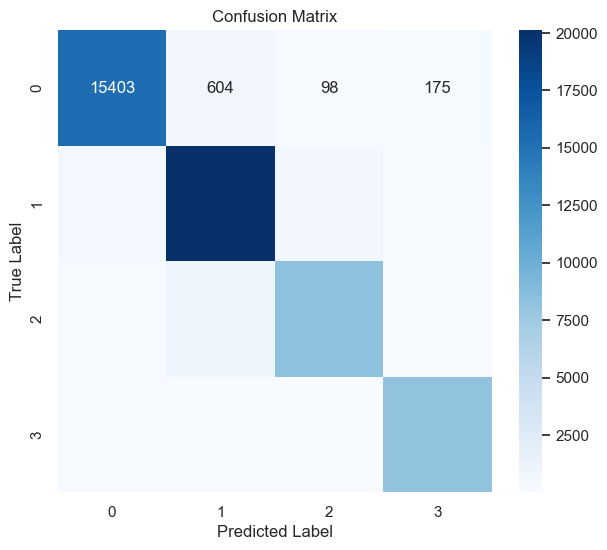

In [48]:
# Confusion matrix

forest_cm = confusion_matrix(y_test, forest_preds)
print(forest_cm)

# Plot confusion matrix

plt.figure(figsize=(7,6))
sns.heatmap(forest_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
#Initialize LightGBM Classifier

LGBM = LGBMClassifier(objective='multiclass', random_state=5)

In [50]:
# 10-fold cross-validation

scores = cross_val_score(LGBM, X_train, y_train, cv=10, scoring="f1_weighted")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 198907, number of used features: 11
[LightGBM] [Info] Start training from score -1.218474
[LightGBM] [Info] Start training from score -0.961775
[LightGBM] [Info] Start training from score -1.776319
[LightGBM] [Info] Start training from score -1.878329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 198907, number of used features: 11
[LightGBM] [Info] Start training from score -1.218474
[LightGBM] [Info] Start training from score -0.961775
[LightGBM] [Info] Start training from score -1.776319
[LightGBM] [Info] Start training from scor

In [51]:
#Preview the cross validation scores

scores

array([0.96332721, 0.95746633, 0.95882401, 0.9612517 , 0.96004282,
       0.95828073, 0.95871466, 0.96097406, 0.96152816, 0.96106382])

In [52]:
# Fit model

LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 221008, number of used features: 11
[LightGBM] [Info] Start training from score -1.218472
[LightGBM] [Info] Start training from score -0.961779
[LightGBM] [Info] Start training from score -1.776314
[LightGBM] [Info] Start training from score -1.878330


LGBMClassifier(objective='multiclass', random_state=5)

In [53]:
# Predict on test set

lgbm_preds = LGBM.predict(X_test)
lgbm_preds

array([1, 3, 1, ..., 1, 1, 2], dtype=int64)

In [54]:
# Print classification report

print(classification_report(y_test, lgbm_preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     16280
           1       0.95      0.96      0.96     21256
           2       0.94      0.93      0.93      9308
           3       0.98      0.98      0.98      8408

    accuracy                           0.96     55252
   macro avg       0.96      0.96      0.96     55252
weighted avg       0.96      0.96      0.96     55252



In [55]:
# Predict probabilities for ROC AUC

lgbm_prob = LGBM.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, lgbm_prob, multi_class='ovr', average='weighted')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9974940978485832


[[15633   435    89   123]
 [  343 20418   458    37]
 [   53   597  8653     5]
 [   98    40     8  8262]]


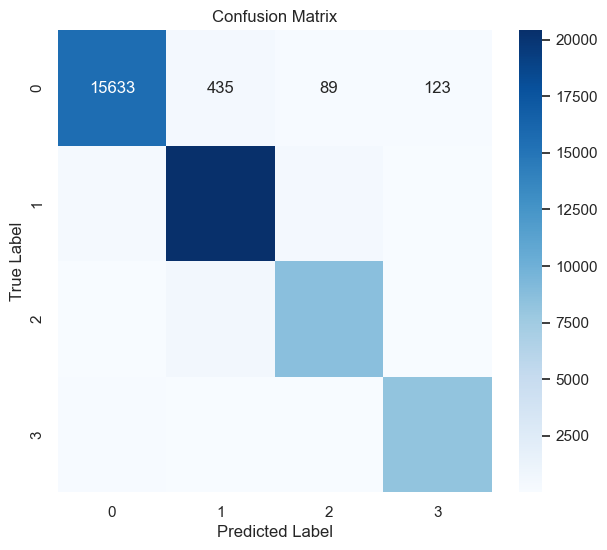

In [56]:
# Confusion matrix

lgbm_cm = confusion_matrix(y_test, lgbm_preds)
print(lgbm_cm)

# Plot confusion matrix

plt.figure(figsize=(7,6))
sns.heatmap(lgbm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Model Evaluation – Conclusion

Four models were trained and evaluated: **Logistic Regression**, **Decision Tree**, **Random Forest**, and **LGBM**.  
Among them, the **LGBM model achieved the best overall performance**, with a **weighted F1-score of 0.96** and a **weighted ROC AUC of 0.997**.

Further hyperparameter optimization was not conducted because the current LGBM configuration already delivers strong and stable performance suitable for real-world deployment.  
Confidence that the model is not overfitting comes from the observation that the **cross-validation F1-scores fall within the same range as the test F1-score**, demonstrating consistent generalization across folds.

Based on performance metrics and stability, **LGBM is selected as the final and best-performing model** for deployment.


## Feature Importance – LGBM

Feature importance analysis helps interpret the model by identifying which input features contribute most to prediction outcomes.  
Understanding these contributions improves transparency and supports better monitoring in production environments.

In [57]:
# Light GBM: analyze feature importance
# Feature importance shows which features the model uses most to reduce prediction error

importances = LGBM.feature_importances_
importances

array([ 592, 1357, 1406,  913,  778, 1728, 1650,  531, 1217,  793, 1035])

In [58]:
# Extract feature names from the dataset

features = X.columns
features

Index(['duration (ms)', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'spec_rate'],
      dtype='object')

In [59]:
# Create a DataFrame with features and their corresponding importance scores

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order

importance_df.sort_values(by="Importance", ascending=False, inplace=True)

In [60]:
# Display the top features by importance

importance_df

,Feature,Importance
5,acousticness,1728
6,instrumentalness,1650
2,energy,1406
1,danceability,1357
8,valence,1217
10,spec_rate,1035
3,loudness,913
9,tempo,793
4,speechiness,778
0,duration (ms),592


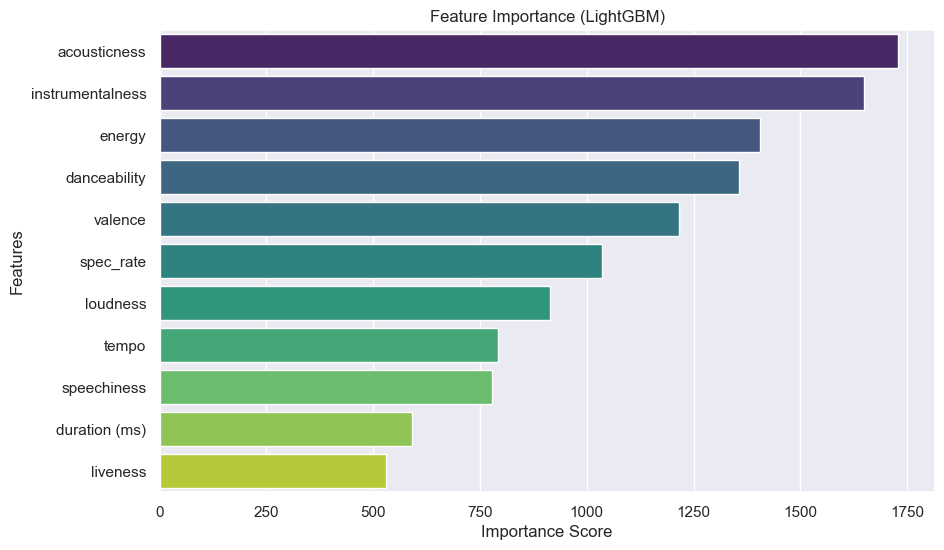

In [61]:
# LightGBM: visualize feature importance using Seaborn
plt.figure(figsize=(10,6))

# Create a horizontal bar plot
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.sort_values(by='Importance', ascending=False),
    palette='viridis'
)

# Add title and labels
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Feature Importance – Conclusion

The feature importance analysis reveals that **acousticness** and **instrumentalness** are the most influential variables in the LGBM model. This indicates that the presence of acoustic elements and instrumental content plays a major role in determining the predicted mood or class of a track.

Following closely are **energy**, **danceability**, and **valence**, which are strongly associated with the emotional and rhythmic characteristics of music. Their high importance scores confirm that the model relies heavily on core audio descriptors that reflect intensity, movement, and positivity of a song.

Mid-level contributors such as **spec_rate**, **loudness**, and **tempo** further enhance the model’s decision-making by capturing spectral properties and pace-related information.

Features such as **speechiness**, **duration (ms)**, and **liveness** have comparatively lower importance. While they still contribute to the prediction process, their influence is less significant relative to the top-ranked features.

Overall, the importance distribution demonstrates that the LGBM model prioritizes meaningful acoustic and rhythmic characteristics when making predictions. This alignment between domain-relevant features and model behavior strengthens confidence in the model’s reliability and interpretability.


### Saving and Loading the Trained Model  

This section demonstrates how to **save** the trained **LGBM classification model** as a `.pkl` file and **load** it later for real-time mood prediction.  

By using **Pickle**, the Spotify mood classification model can be stored and reused without retraining. This ensures consistent predictions, reduces computational overhead, and enables smooth deployment in production environments such as web dashboards or music recommendation systems.  

Saving the finalized LGBM model preserves the optimized parameters and learned patterns from the training data. This guarantees that the same high-performing model—validated through cross-validation and test evaluation—can be reliably used during inference, evaluation, or integration into intelligent music analytics platforms.


In [62]:
# -----------------------------------------
# Save the Trained and Optimized LGBM Model
# -----------------------------------------

# Define the file path for saving the trained LGBM model
save_model_path = "Spotify_LGBM_Model.pkl"

# Save the trained LGBM model using pickle
with open(save_model_path, "wb") as file:
    pickle.dump(LGBM, file)

print("LGBM model successfully saved.")

# Define the file path to store the StandardScaler
save_scaler_path = "Spotify_scaler.pkl"

# Save the scaler to ensure consistent feature scaling during inference
with open(save_scaler_path, 'wb') as file:
    pickle.dump(scale, file)

print("Feature scaler successfully saved.")

LGBM model successfully saved.
Feature scaler successfully saved.


### Saving and Loading the Trained Model – Conclusion  

The trained **LGBM classification model** has been successfully saved as a `.pkl` file to ensure efficient reuse without retraining.  
By serializing the model using **Pickle**, the learned patterns, optimized hyperparameters, and decision structure are preserved exactly as validated during evaluation.

This approach guarantees consistent and reproducible predictions during deployment. It also reduces computational cost, since the model does not need to be retrained each time predictions are required.

With the model securely stored and easily reloadable, the Spotify mood classification system is now fully prepared for real-world integration, enabling scalable, reliable, and production-ready inference.


## Conclusion

Moodify successfully predicts the emotional label of Spotify tracks using audio features. LightGBM achieved the best performance with an F1 score of **0.96** in cross-validation.  

The project demonstrates the power of machine learning in music analysis, providing:  
- High-accuracy emotion classification for songs.  
- Interpretability via feature importance insights.  
- A user-friendly interface for live predictions.  

This foundation can be extended to generate personalized playlists and deeper user-music profiling, making music recommendation smarter and more emotionally aware.